### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time
import h5py
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2022-09-20 10:17:23.443886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 10:17:23.443929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### data 

In [2]:
test = h5py.File("small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_s[:],
                                                  y_s[:],
                                                  test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [4]:
div = np.max(x_train,axis=(1,2)).reshape(x_train.shape[0],1,1)
div[div == 0] = 1
x_train = x_train / div

div = np.max(x_val,axis=(1,2)).reshape(x_val.shape[0],1,1)
div[div == 0] = 1
x_val = x_val / div

div = np.max(x_test,axis=(1,2)).reshape(x_test.shape[0],1,1)
div[div == 0] = 1
x_test = x_test / div

# Circuit

In [5]:
DATA_QBITS = 4
TOTAL_QBITS = DATA_QBITS

INPUT_DATA_SIZE = 12

DRCs = 2

In [6]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [7]:
def single_upload(params, data, wire):
    for i, d in enumerate(data.flatten()):
        if i % 3 == 0:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
            #qml.RZ(params[i], wires=wire)
            #qml.RZ(d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
            #qml.RY(params[i], wires=wire)
            #qml.RY(d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
            #qml.RZ(params[i], wires=wire)
            #qml.RZ(d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,img.shape[1]-kernel_size+1,stride)))*len(list(range(0,img.shape[0]-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    for y in range(0,img.shape[1]-kernel_size+1,stride):
        for x in range(0,img.shape[0]-kernel_size+1,stride):
            single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                          img[y:y+kernel_size, x:x+kernel_size], wires[wire])
            upload_counter = upload_counter + 1
            wire = wire + 1
            
def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1, diff_method="adjoint")
def circuit(params, data):

    kernel_size = 6
    stride = 6
    
    number_of_kernel_uploads = len(list(range(0,data.shape[1]-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(params[i*num_upload_params:(i+1)*num_upload_params], data, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    #return [qml.expval(qml.PauliZ(i)) for i in range(DATA_QBITS)]
    return qml.expval(qml.PauliZ(3))

In [8]:
@qml.qnode(dev1, diff_method="adjoint")
def visual_latent(params, data, gate):

    kernel_size = 6
    stride = 6
    
    number_of_kernel_uploads = len(list(range(0,data.shape[1]-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    #num_upload_params = number_of_kernel_uploads*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(params[i*num_upload_params:(i+1)*num_upload_params], data, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    return qml.expval(gate(3))

In [9]:
data = np.random.rand(INPUT_DATA_SIZE,INPUT_DATA_SIZE)

kernel_size = 6
stride = 6
number_of_kernel_uploads = len(list(range(0,data.shape[0]-kernel_size+1,stride)))**2
num_upload_params = number_of_kernel_uploads*2*kernel_size**2
#num_upload_params = number_of_kernel_uploads*kernel_size**2

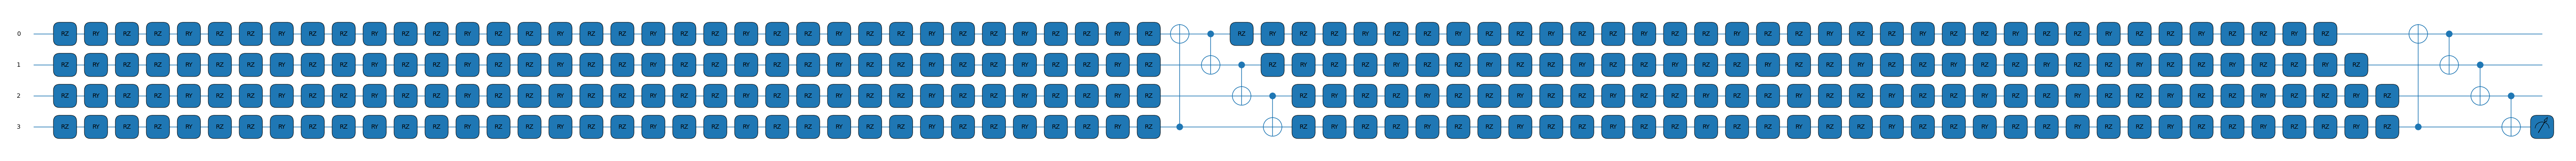

In [10]:
fig, ax = qml.draw_mpl(circuit)(np.ones(DRCs*num_upload_params),data)
fig.show()

In [11]:
def cost_batch(params, xbatch, ybatch):
    loss = 0.0
    for x,y in zip(xbatch,ybatch):
        f = circuit(params[1:], x)
        loss = loss + (y - params[0]*np.mean(f)) ** 2
    return loss / len(xbatch)

def cost_sample(params, x, y):
    loss = 0.0
    f = circuit(params, x)
    loss = loss + (y - f) ** 2
    return loss

In [12]:
def iterate_minibatches(data, y, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs], y[idxs]

In [13]:
learning_rate = 0.001
epochs = 25
batch_size = 40

In [14]:
qml.about()

Name: PennyLane
Version: 0.26.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/tom/.conda/envs/tfq/lib/python3.9/site-packages
Requires: pennylane-lightning, autograd, retworkx, autoray, cachetools, toml, semantic-version, numpy, appdirs, scipy, networkx
Required-by: PennyLane-qiskit, PennyLane-Lightning, PennyLane-Cirq

Platform info:           Linux-5.19.0-1-amd64-x86_64-with-glibc2.34
Python version:          3.9.12
Numpy version:           1.23.0
Scipy version:           1.8.1
Installed devices:
- lightning.qubit (PennyLane-Lightning-0.26.0)
- default.gaussian (PennyLane-0.26.0)
- default.mixed (PennyLane-0.26.0)
- default.qubit (PennyLane-0.26.0)
- default.qubit.autograd (PennyLane-0.26.0)
- default.qubit.jax (PennyLane-0.26.0)
- default.qubit.tf (PennyLane-0.26.0)
- default.qubit.torch (PennyLane-0.26.0)
- default.qutrit (PennyLane-0

In [15]:
#opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
opt = qml.QNSPSAOptimizer() 
#opt = qml.NesterovMomentumOptimizer()
#opt = qml.RMSPropOptimizer(0.001)
#opt = qml.QNGOptimizer(learning_rate)
# opt = GradientDescentOptimizer(learning_rate)

In [16]:
weight_shapes = {"weights": (DRCs*num_upload_params + 1)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [17]:
x_train_small = x_train[:4000]
y_train_small = y_train[:4000]

x_test_small = x_test[:1200]
y_test_small = y_test[:1200]

In [18]:
start = time.time()

gradient_means = []
gradient_vars = []

for it in range(epochs):
    start_b = time.time()
    for j, batch in enumerate(iterate_minibatches(x_train_small, y_train_small, batch_size=batch_size)):  
    #for j, sample in enumerate(zip(x_train_small,y_train_small)):
        #x, y = sample 
        #x = np.array(x, requires_grad=False)
        #y = np.array(y, requires_grad=False)
        x, y = batch
        #cost_fn = lambda p: cost_sample(p, x, y)
        cost_fn = lambda p: cost_batch(p, x, y)
        #metric_fn = lambda p: qml.metric_tensor(circuit, approx="diag")(p, x)
        params = opt.step(cost_fn, params)#, metric_tensor_fn=metric_fn) 
        print(j, end="\r")
        
        grad = qml.grad(cost_fn)
        gradient = grad(params)
        gradient_means.append(np.mean(gradient))
        gradient_vars.append(np.std(gradient))
        
        if j % 20 == 0:
            end_b = time.time()
            loss = cost_batch(params,x,y)
            print(f"Step: {j} | Loss: {loss:.3} | avg step time {(end_b - start_b) / 20 :.3}")
            start_b = time.time()

    loss = cost_batch(params,x_train_small[:100], y_train_small[:100])
    val_loss = cost_batch(params, x_test_small[:100], y_test_small[:100])
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.4} | Val Loss {val_loss:.4}")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

AttributeError: 'function' object has no attribute 'construct'

In [ ]:
plt.plot(gradient_means)
print(np.mean(gradient_means))
#plt.yscale('log')
plt.ylim(-0.003,0.003)

In [ ]:
plt.plot(gradient_vars)

In [ ]:
pred = np.array([circuit(params,i) for i in x_test_small])

In [ ]:
pred_0 = pred[y_test_small == 0][:500]
pred_1 = pred[y_test_small == 1][:500]

bins = np.histogram(np.hstack((pred_0.reshape((pred_0.shape[0],)), pred_1.reshape((pred_1.shape[0],)))), bins=100)[1]
plt.hist(pred_0, histtype='step', label="0",bins=bins)
plt.hist(pred_1, histtype='step', label="1",bins=bins)
#plt.xlim(0.2,0.65)
plt.legend()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(y_test_small, pred)

print(auc)

fpr, tpr, thresholds = roc_curve(y_test_small, pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

In [ ]:
from qutip import Bloch

In [ ]:
visual_latent

x_test_bgs = x_test_small[y_test_small == 0]
x_test_signals = x_test_small[y_test_small == 1]

def plot_latent_space(x_test_bg, x_test_signal):
    b = Bloch()
    points_bg_x = [visual_latent(params, i,qml.PauliX) for i in x_test_bg]
    points_bg_y = [visual_latent(params, i,qml.PauliY) for i in x_test_bg]
    points_bg_z = [visual_latent(params, i,qml.PauliZ) for i in x_test_bg]

    points_signal_x = [visual_latent(params, i,qml.PauliX) for i in x_test_signal]
    points_signal_y = [visual_latent(params, i,qml.PauliY) for i in x_test_signal]
    points_signal_z = [visual_latent(params, i,qml.PauliZ) for i in x_test_signal]
    
    
    bloch_points_bg = [points_bg_x,points_bg_y,points_bg_z]
    b.add_points(bloch_points_bg)

    bloch_points_sig = [points_signal_x,points_signal_y,points_signal_z]
    b.add_points(bloch_points_sig)
    
    b.show()
    
plot_latent_space(x_test_bgs[:100], x_test_signals[:100])

In [ ]:
loss = np.array([0.246, 0.244, 0.243, 0.243, 0.242, 0.242, 0.241, 0.241, 0.24, 0.24, 0.24, 0.239, 0.239,  0.238, 0.238, 0.237])
val_loss = np.array([0.274, 0.259, 0.256, 0.255, 0.254, 0.253, 0.252, 0.252, 0.251, 0.251, 0.251, 0.25, 0.25, 0.25, 0.25, 0.251])